# High Winds - IFS
---

Here we will focus on:
- [`10u`](https://codes.ecmwf.int/grib/param-db/165) 10 metre U wind component,
- [`10v`](https://codes.ecmwf.int/grib/param-db/166) 10 metre V wind component,
- [`10fg3`](https://codes.ecmwf.int/grib/param-db/228028) maximum 10 metre wind gust in the last 3 hours, and
- [`10fgg15`](https://codes.ecmwf.int/grib/param-db/131070) 10 metre wind gusts of at least 15 m/s of the **IFS** datasets on 7 January 2025 in Sweden (58.58° N, 11.07° E).

:::{tip}
If you have not visited the [High Winds - AIFS](./damaging-winds-aifs.ipynb) website yet, we highly recommend you to do so before proceeding further with the analysis.
:::

## 1. Set Up Your Environment and Find ECMWF Open Data
If the packages are not installed yet, uncomment the code below and run it.

In [ ]:
# !pip3 install earthkit ecmwf-opendata xarray

In [1]:
from ecmwf.opendata import Client
import earthkit.data as ekd
import earthkit.plots as ekp

import xarray as xr
xr.set_options(keep_attrs=True)

(content:references:listParam_dwi)=
### List of parameters to retrieve from open datasets
The selected values below can be modified.

- Parameters available on a single level:

In [27]:
PARAM_SFC = ["10u", "10v"]
LEVELTYPE = "sfc"

DATES = [20250107]
TIME = 0
STEPS = 0
STREAM = "enfo"
TYPE = ["cf", "pf"]
MODEL = "ifs"

To calculate the probabilities of 10 m wind speed, we need both the `cf` and `pf` type. This means that we will download the control forecast as well as all 50 ensemble members. <br>
In case you want to download individual ensemble members, specify the type of data `type=pf` and the list of ensemble member numbers `number=[1, 2, 3, ...]`.

(content:references:getData_dwi)=
### Get the data using the ECMWF Open Data API

In [2]:
def get_open_data(date, time, step, stream, _type, model, param, leveltype, levelist=[]):
    client = Client(source="aws")
    list_of_files = []
    # Get the data for all dates
    for _date in DATES:
        filename = f"{model}_{''.join(param)}_{''.join(map(str, levelist))}_{_date}.grib2" if levelist else f"{model}_{''.join(param)}_{leveltype}_{_date}.grib2"
        data = client.retrieve(
            date=_date,
            time=time,
            step=step,
            stream=stream,
            type=_type,
            levtype=leveltype,
            levelist=levelist,
            param=param,
            model=model,
            target=filename
            )
        list_of_files.append(filename)
    return data, list_of_files

## 2. Wind speed probabilities

When using the `ls()` method, a list of all the fields in the file we downloaded will be displayed. Note that the ensemble member numbers are not sorted in an ascending or descending order.

In [4]:
data, list_of_files = get_open_data(date=DATES,
                                    time=TIME,
                                    step=STEPS,
                                    stream=STREAM,
                                    _type=TYPE,
                                    model=MODEL,
                                    param=PARAM_SFC,
                                    leveltype=LEVELTYPE,
                                    levelist=[])

# Select IFS model data on 7 January 2025
ds = ekd.from_source("file", list_of_files[0])
ds.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,10v,heightAboveGround,10,20250107,0,0,pf,41,regular_ll
1,ecmf,10v,heightAboveGround,10,20250107,0,0,pf,14,regular_ll
2,ecmf,10v,heightAboveGround,10,20250107,0,0,pf,23,regular_ll
3,ecmf,10v,heightAboveGround,10,20250107,0,0,pf,32,regular_ll
4,ecmf,10u,heightAboveGround,10,20250107,0,0,pf,6,regular_ll
...,...,...,...,...,...,...,...,...,...,...
97,ecmf,10u,heightAboveGround,10,20250107,0,0,pf,50,regular_ll
98,ecmf,10v,heightAboveGround,10,20250107,0,0,pf,40,regular_ll
99,ecmf,10v,heightAboveGround,10,20250107,0,0,pf,5,regular_ll
100,ecmf,10u,heightAboveGround,10,20250107,0,0,pf,23,regular_ll


The `describe()` method provides an overview of a selected parameter.

In [5]:
ds.describe("10u")

shortName,10u
typeOfLevel,heightAboveGround
level,10
date,20250107
time,0
step,0
number,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50"
paramId,165
class,od
stream,enfo
type,"pf,cf"


We will sort the ensemble member numbers (for `10u` and `10v`), then using the `head()` method, we will display the first 5 messages.

In [6]:
ds = ds.order_by(["number"])
ds.head()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,10u,heightAboveGround,10,20250107,0,0,cf,0,regular_ll
1,ecmf,10v,heightAboveGround,10,20250107,0,0,cf,0,regular_ll
2,ecmf,10u,heightAboveGround,10,20250107,0,0,pf,1,regular_ll
3,ecmf,10v,heightAboveGround,10,20250107,0,0,pf,1,regular_ll
4,ecmf,10u,heightAboveGround,10,20250107,0,0,pf,2,regular_ll


We will calculate the wind speed from u and v components and create a new fieldlist with a single field containing new values. The metadata of the `10u` field will be modified.

In [7]:
dsx = ds.to_xarray()
u = dsx['10u']
v = dsx['10v']
speed = xr.ufuncs.sqrt(u**2 + v**2)
speed = speed.assign_attrs(u.attrs)
speed.attrs['param'] = '10uv'
speed.attrs['standard_name'] = 'unknown'
speed.attrs['long_name'] = '10 metre wind speed'
speed.attrs['paramId'] = 'unknown'
speed

<xarray.DataArray (number: 51, latitude: 721, longitude: 1440)> Size: 424MB
array([[[4.57739419, 4.57739419, 4.57739419, ..., 4.57739419,
         4.57739419, 4.57739419],
        [4.43535192, 4.4333944 , 4.43149112, ..., 4.42825408,
         4.4415491 , 4.43942934],
        [4.17928579, 4.17802645, 4.17682517, ..., 4.18490281,
         4.18341173, 4.18060316],
        ...,
        [6.50958104, 6.5050557 , 6.49199856, ..., 6.52358731,
         6.51884699, 6.51417819],
        [6.70098217, 6.70478178, 6.69570021, ..., 6.68564163,
         6.70223172, 6.69736267],
        [6.93216913, 6.93216913, 6.93216913, ..., 6.93216913,
         6.93216913, 6.93216913]],

       [[4.86915628, 4.86915628, 4.86915628, ..., 4.86915628,
         4.86915628, 4.86915628],
        [4.62676987, 4.62241052, 4.62030856, ..., 4.61825527,
         4.63133598, 4.62902711],
        [4.35070242, 4.34992863, 4.34854907, ..., 4.35335947,
         4.35241787, 4.35153218],
...
        [6.01504419, 6.00611332, 6.01179597, ..., 6.02760854,
         6.01849349, 6.00944587],
        [6.88341836, 6.88951113, 6.88908563, ..., 6.87877576,
         6.87767518, 6.8908935 ],
        [7.09372423, 7.09372423, 7.09372423, ..., 7.09372423,
         7.09372423, 7.09372423]],

       [[4.40412187, 4.40412187, 4.40412187, ..., 4.40412187,
         4.40412187, 4.40412187],
        [4.160382  , 4.15783152, 4.17076835, ..., 4.15578374,
         4.16837551, 4.16565411],
        [3.94637269, 3.94504552, 3.94377981, ..., 3.95072232,
         3.94921116, 3.94776126],
        ...,
        [6.75880957, 6.7550275 , 6.7605148 , ..., 6.77216994,
         6.76277003, 6.75342933],
        [6.77629964, 6.77447369, 6.77282748, ..., 6.75400171,
         6.7660922 , 6.76393865],
        [7.00928581, 7.00928581, 7.00928581, ..., 7.00928581,
         7.00928581, 7.00928581]]], shape=(51, 721, 1440))
Coordinates:
  * number     (number) int64 408B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Attributes:
    param:          10uv
    standard_name:  unknown
    long_name:      10 metre wind speed
    paramId:        unknown
    units:          m s**-1
    _earthkit:      {'message': b'GRIB\xff\xff\x00\x02\x00\x00\x00\x00\x00\x0...

We will set values to 1 where the wind speed is higher than 10 m/s and to 0 where it is lower than 10 m/s.

In [8]:
speed01 = speed > 10

From there on we calculate the probability of the wind speed which is higher than 10 m/s, we calculate the mean of all the ensemble member numbers.

In [9]:
mean_ws = speed01.mean("number") * 100
mean_ws

<xarray.DataArray (latitude: 721, longitude: 1440)> Size: 8MB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.96078431, 1.96078431, 1.96078431, ..., 1.96078431, 1.96078431,
        1.96078431],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(721, 1440))
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Attributes:
    param:          10uv
    standard_name:  unknown
    long_name:      10 metre wind speed
    paramId:        unknown
    units:          m s**-1
    _earthkit:      {'message': b'GRIB\xff\xff\x00\x02\x00\x00\x00\x00\x00\x0...

The `tail()` method displays the last 5 messages when the `n` argument is not provided.

In [10]:
prob_ws = mean_ws.earthkit.to_fieldlist()
prob_ws.tail()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,10u,heightAboveGround,10,20250107,0,0,cf,0,regular_ll


:::{note}
Since the data array `mean_ws` is decoupled from the metadata object, accessing metadata related to the data values is not possible and will throw an exception.
The shortname of the `prob_ws` fieldlist is `10u` instead of `ws`.
:::

## 4. Wind gust
The input values can be set [here](#content:references:listParam_dwi).

In [5]:
PARAM_SFC = "10fg"
LEVELTYPE = "sfc"

DATES = [20250107]
TIME = 0
STEPS = 3
STREAM = "oper"
TYPE = "fc"
MODEL = "ifs"

When using the `describe()` method, a given parameter defined by `shortName` will be described.

In [13]:
data, list_of_files = get_open_data(date=DATES,
                                    time=TIME,
                                    step=STEPS,
                                    stream=STREAM,
                                    _type=TYPE,
                                    model=MODEL,
                                    param=PARAM_SFC,
                                    leveltype=LEVELTYPE,
                                    levelist=[])

# Select IFS model data on 7 January 2025
wg = ekd.from_source("file", list_of_files[0])
wg.describe("10fg")

shortName,10fg
typeOfLevel,heightAboveGround
level,10
date,20250107
time,0
step,3
number,None
paramId,49
class,od
stream,oper
type,fc


## 5. Data visualisation

The plot below shows analysis of wind speed probabilities on 7 January 2025.

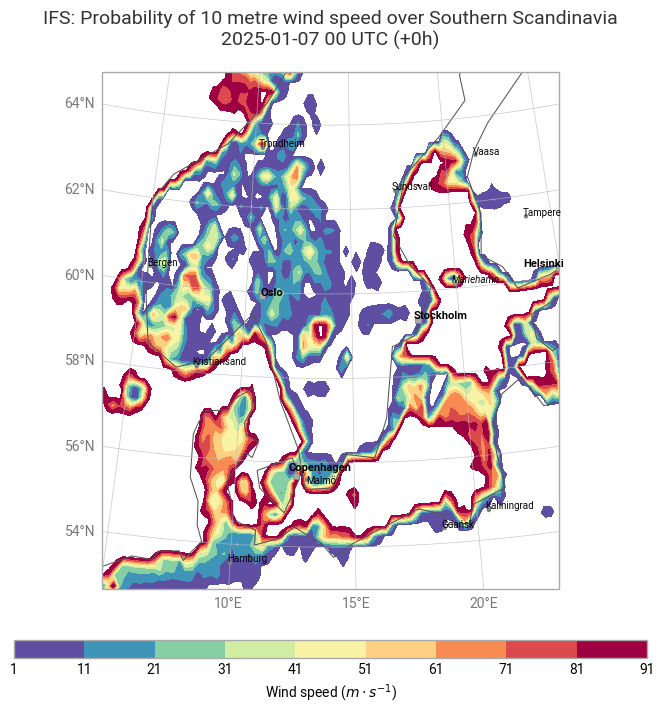

In [28]:
chart = ekp.Map(domain=[5, 23, 53, 65])

ws_style = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(1, 100, 10),
    units="m/s",
)

chart.contourf(prob_ws, style=ws_style)

chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(adjust_labels=True)

chart.legend(location="bottom", label="Wind speed ({units})")

chart.title(
    "IFS: Probability of 10 metre wind speed over Southern Scandinavia\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)
chart.save(f"./plots/{''.join(PARAM_SFC)}_{MODEL}_{DATES[0]}{TIME}-{STEPS}h.png")
chart.show()

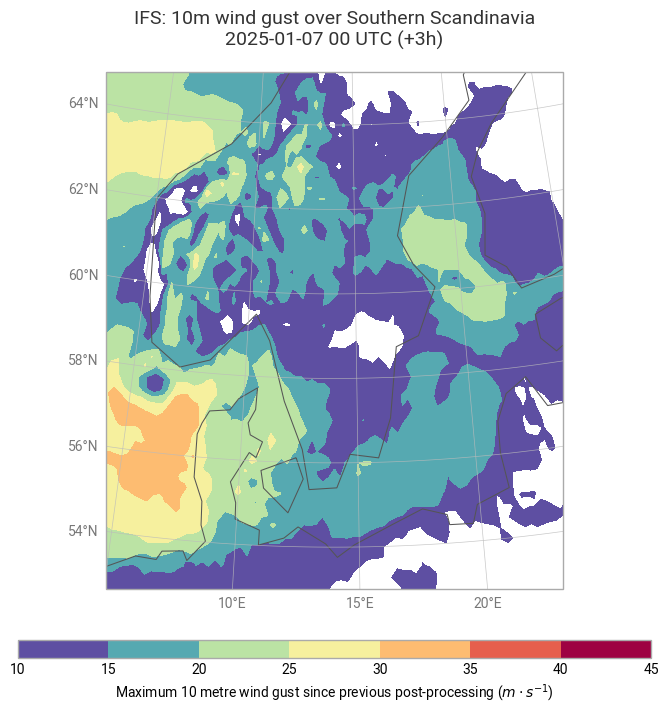

In [12]:
chart = ekp.Map(domain=[5, 23, 53, 65])

wg_shade = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(10, 50, 5),
    units="m/s",
    transform_first=True,
)

chart.contourf(wg, style=wg_shade)

chart.coastlines(resolution="low")
chart.gridlines()

chart.legend(location="bottom", label="{variable_name} ({units})")

chart.title(
    "IFS: 10m wind gust over Southern Scandinavia\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)
chart.save(f"./plots/{PARAM_SFC}_{MODEL}_{DATES[0]}{TIME}-{STEPS}h.png")
chart.show()

_To be continued_